# Reverse engineering learned optimizers

**Nov 4 2020**

Contact: Niru Maheswaranathan ([@niru_m](https://twitter.com/niru_m))

In this notebook, we will walk through the analysis in the following paper: [Reverse engineering learned optimizers reveals known and novel dynamics](https://arxiv.org/abs/2011.02159).

This paper studies the mechanisms and behaviors in _learned_ optimization algorithms. These are algorithms (in contrast to hand designed algorithms such as gradient descent or momentum) that are trained to do optimization. For details about how these work, and what we found by studying them, check out the paper.

In this notebook, we will walk through how to run these optimizers, using pre-trained weights that you can download.

## Imports

First, we import the packages we will need. Most of these are standard in the scientific python community (NumPy, SciPy, Matplotlib). [JAX](https://jax.readthedocs.io/) is a machine learning library we use for building models with autodifferentiation support. The [ml_collections](https://github.com/google/ml_collections) package is a small library of collections designed for machine learning use cases, we use the `ConfigDict` object in that package to store configuration details about a given model.

Finally, the [renn](https://github.com/google-research/reverse-engineering-neural-networks) package contains utilities for training and analyzing recurrent neural networks (RNNs).

All of these packages can be installed via [pip](https://pip.pypa.io/en/stable/) (e.g. run `pip install renn` to install the renn package).

In [1]:
import os
import pathlib
import yaml

import jax
import jax.numpy as jnp

from jax.experimental import optimizers
from jax.experimental import stax

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

from ml_collections import ConfigDict

import renn
from renn import metaopt
print(f'Using renn v{renn.__version__}')

Using renn v0.0.13


## Setup

We provide trained weights for the optimizers analyzed in the paper at this [Google Drive link](https://drive.google.com/drive/folders/1OqwqBVIqA_U9t-SztPwzoW58B3qDxFwN?usp=sharing). **You will need to download these files to your machine in order to run this notebook.** Each folder contains a different model, corresponding to the different tasks (optimization problems) that they were trained on.

The `config.yml` file is a yaml file containing information about the model, and the `theta.bin` file is a serialized file containing NumPy arrays that store the trained weights for the model.

You can load these files using the following helper function:

In [2]:
def load_model(basedir):
    """Loads trained weights and configuration file from a given directory.
    
    Args:
        basedir: str, Specifies the directory where the config.yml and theta.bin files are saved.
    
    Returns;
        cfg: An ml_collections ConfigDict object containing the configuration parameters for this model.
        theta: A JAX pytree containing the trained weights for the model.
    """
    with open(pathlib.Path(basedir) / 'config.yml', 'r') as f:
        cfg = yaml.load(f)
        
    with open(pathlib.Path(basedir) / 'theta.bin', 'rb') as f:
        theta = renn.load(f)
    
    return cfg, theta

In this notebook, we will analyze the learned optimizer trained on the Quadratic task. Assuming you have downloaded those files to the `~/Downloads` folder (you may need to change the base directory depending on where you saved your files), let's load the model:

In [3]:
# You may need to change this depending on where you saved your files.
basedir = os.path.expanduser('~/Downloads/Quadratic')

# This notebook analyzes a learned optimizer trained on the Quadratic task.
cfg, theta = load_model(basedir)

# This will print out some configuration information about the experiment.
print(cfg)

adam:
  eps: 4.529839901619837e-06
  omb1: 0.19360588076250435
  omb2: 0.4064297061076916
batch_size: 64
clip_value: 0.047261480715151634
input_scale: 1.0
l2_pen: 1.0e-06
lr:
  decay_rate: 0.5546520268275907
  decay_steps: 1000
  step_size: 0.0007836616188084271
num_inner_steps: 201
num_layers: 1
num_outer_steps: 5000
num_units: 256
output_scale: 1.0
save_bin: false
save_every: 100
seed: 675
task: quadratic



<ipython-input-2-91aa130a5429>:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(f)


## Building learned optimizers

In this paper, we parameterize optimization algorithms using recurrent neural networks (RNNs). First, let's rebuild the RNN model. We used single layer gated recurrent units (GRUs):

In [4]:
# Build optimizer RNN
layers = [(renn.GRU(cfg.num_units), stax.Identity)]
cell = renn.StackedCell(layers)

print(type(cell))

<class 'renn.rnn.cells.StackedCell'>


The `cell` is an StackedCell object from the `renn` package that makes it easy to analyze the RNN. It's similar to RNN cells implemented in other popular machine learning libraries.

The learned optimizer we have trained in the paper is what we call a "component-wise" RNN optimizer. This just means that the optimizer gets applied to each parameter in the target problem independently (this is how most first-order optimization algorithms work). We build our component-wise RNN (cwrnn) optimizer using the following helper function:

In [5]:
model_key = jax.random.PRNGKey(0)
theta_init, optimizer_fun = metaopt.models.cwrnn(model_key, cell, input_scale=cfg.input_scale, output_scale=cfg.output_scale)

/Users/nirum/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Here, `input_scale` and `output_scale` are problem specific scalars that were separately tuned for each task. For the Quadratic task, they are both set to one. `theta_init` is a JAX pytree containing initial weights for the learned optimizer. It has the same structure as the final weights (`theta`) that we loaded above.

Finally, the `optimizer_fun` is a function that takes in optimizer parameters (e.g. `theta`) and returns a [JAX optimizer](https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html) triple of functions that we can use to solve optimization problems:

In [6]:
cwrnn = optimizer_fun(theta)

print(f'We have {len(cwrnn)} functions that form an optimizer tuple:')
for func in cwrnn:
    print(func.__name__)

We have 3 functions that form an optimizer tuple:
init_state
update_opt
get_params


## Loading a task (optimization problem) to run the optimizer on

Let's run this optimizer on the task that it was trained on, the Quadratic task:

In [7]:
# For this task, these hyperparameters specify the number of problem parameters (5),
# and the min and max eigenvalues that control the condition number of the problem,
# specified as log10 of the eigenvalue. So here, the min and max eigenvalue range is (10^-3, 10^0).
task = metaopt.tasks.quad(5, -3, 0)

A task is a function that takes a JAX random key, and returns two things: (1) intial parameters for the optimization problem, and (2) a loss function:

In [8]:
test_key = jax.random.PRNGKey(seed=1234)  # Changing this seed will sample a new test problem.

x0, loss_fun = task(test_key)

print(f'Initial loss: {loss_fun(x0, _)}')

Initial loss: 251.5458221435547


## Run the learned optimizer

To run an optimizer, we will use the following helper function, which takes a test key and an optimizer and runs it on our task for 100 iterations:

In [9]:
def run_optimizer(optimizer_tuple, test_key):
    num_iterations = 101
    return metaopt.unroll_scan(*task(test_key), optimizer_tuple, num_iterations, renn.identity)[1]

In [10]:
# This function returns an array containing the loss at each iteration
losses_after_training = run_optimizer(optimizer_fun(theta), test_key)

# For comparison, we'll also run the optimizer using the _initial_ optimizer weights (before meta-training)
losses_before_training = run_optimizer(optimizer_fun(theta_init), test_key)

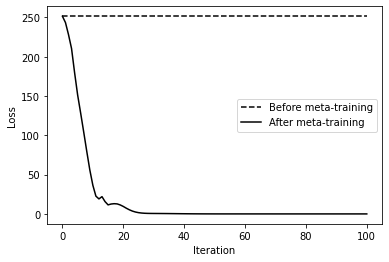

In [11]:
plt.plot(losses_before_training, 'k--', label='Before meta-training')
plt.plot(losses_after_training, 'k-', label='After meta-training')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()